# Lecture 19: Class demo

UBC 2025-26

## Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")

<br><br>

## Demo: A more complicated dataset 

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [2]:
rain_df = pd.read_csv(DATA_DIR + "weatherAUS.csv")
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
rain_df.shape

(145460, 23)

**Questions of interest**

- Can we **forecast** into the future? Can we predict whether it's going to rain tomorrow?
    - The target variable is `RainTomorrow`. The target is categorical and not continuous in this case. 
- Can the date/time features help us predict the target value?


### Exploratory data analysis

In [4]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
rain_df.describe(include="all")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


- A number of missing values. 
- Some target values are also missing. I'm dropping these rows. 

In [6]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

### Parsing datetimes 

- In general, datetimes are a huge pain! 
    - Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [7]:
dates_rain = pd.to_datetime(rain_df["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

They are all the same format, so we can also compare dates:

In [8]:
dates_rain[1] - dates_rain[0] 

Timedelta('1 days 00:00:00')

In [9]:
dates_rain[1] > dates_rain[0]

True

In [10]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

We can also easily extract information from the date columns. 

In [11]:
dates_rain[1]

Timestamp('2008-12-02 00:00:00')

In [12]:
dates_rain[1].month_name()

'December'

In [13]:
dates_rain[1].day_name()

'Tuesday'

In [14]:
dates_rain[1].is_year_end

False

In [15]:
dates_rain[1].is_leap_year

True

Above pandas identified the date column automatically. You can tell pandas to parse the dates when reading in the CSV:

In [16]:
rain_df = pd.read_csv(DATA_DIR + "weatherAUS.csv", parse_dates=["Date"])
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [17]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

In [18]:
rain_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


In [19]:
rain_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [20]:
rain_df.sort_values(by="Date", ascending=False).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6048,2017-06-25,BadgerysCreek,0.8,18.6,0.2,NaN,NaN,WSW,31.0,NaN,...,99.0,40.0,1018.8,1015.5,NaN,NaN,6.9,17.8,No,No
93279,2017-06-25,GoldCoast,12.9,22.4,0.0,NaN,NaN,NNE,26.0,W,...,66.0,64.0,1020.2,1017.3,NaN,NaN,18.2,21.7,No,No
55101,2017-06-25,MountGinini,-5.3,1.9,0.0,NaN,NaN,WSW,70.0,SW,...,96.0,94.0,NaN,NaN,NaN,NaN,-3.2,0.4,No,No
96319,2017-06-25,Townsville,16.5,25.8,0.0,NaN,NaN,ESE,31.0,SE,...,61.0,53.0,1018.1,1015.7,8.0,8.0,22.4,24.6,No,No
52061,2017-06-25,Tuggeranong,-5.8,14.4,0.0,NaN,NaN,W,43.0,SSE,...,86.0,49.0,1018.5,1016.0,NaN,NaN,-0.5,11.3,No,No


### ❓❓ Questions for you
How many time series are present in this dataset? 

<br><br><br><br>

We definitely see measurements on the same day at different locations. 

In [21]:
rain_df.sort_values(by=["Location", "Date"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
96320,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,...,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,No
96321,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,...,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,No
96322,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,...,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,No
96323,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,NNE,30.0,NNE,...,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,No
96325,2008-07-06,Adelaide,11.3,15.7,NaN,NaN,1.5,NNW,52.0,NNE,...,62.0,62.0,1019.5,1016.2,NaN,NaN,13.0,14.4,NaN,Yes


Great! Now we gave a sequence of dates with single row per date. We have a separate timeseries for each region. 

Do we have equally spaced measurements? 

In [22]:
def plot_time_spacing_distribution(df, region="Adelaide"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['Location'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Sydney:
Date
1 days     3327
2 days        5
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



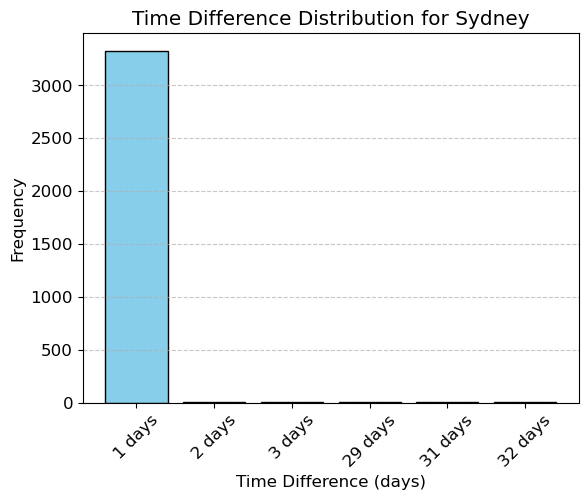

In [23]:
plot_time_spacing_distribution(rain_df, 'Sydney')

The typical spacing seems to be 1 day for each location but there are several exceptions. We seem to have several missing measurements.   

### Train/test splits 

Remember that we should not be calling the usual `train_test_split` with shuffling because if we want to forecast, we aren't allowed to know what happened in the future!

In [24]:
rain_df["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [25]:
rain_df["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [26]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [27]:
len(train_df)

107502

In [28]:
len(test_df)

34691

In [29]:
len(test_df) / (len(train_df) + len(test_df))

0.24397122221206388

As we can see, we're still using about 25% of our data as test data.

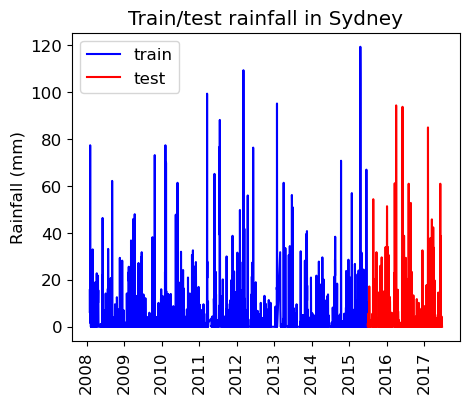

In [30]:
train_df_sort = train_df.query("Location == 'Sydney'").sort_values(by="Date")
test_df_sort = test_df.query("Location == 'Sydney'").sort_values(by="Date")

plt.figure(figsize=(5,4))
plt.plot(train_df_sort["Date"], train_df_sort["Rainfall"], "b", label="train")
plt.plot(test_df_sort["Date"], test_df_sort["Rainfall"], "r", label="test")
plt.xticks(rotation="vertical")
plt.legend()
plt.ylabel("Rainfall (mm)")
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

### Preprocessing

We have different types of features. So let's define a preprocessor with a column transformer. 

In [31]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [32]:
train_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107502 entries, 0 to 144733
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           107502 non-null  datetime64[ns]
 1   Location       107502 non-null  object        
 2   MinTemp        107050 non-null  float64       
 3   MaxTemp        107292 non-null  float64       
 4   Rainfall       106424 non-null  float64       
 5   Evaporation    66221 non-null   float64       
 6   Sunshine       62320 non-null   float64       
 7   WindGustDir    100103 non-null  object        
 8   WindGustSpeed  100146 non-null  float64       
 9   WindDir9am     99515 non-null   object        
 10  WindDir3pm     105314 non-null  object        
 11  WindSpeed9am   106322 non-null  float64       
 12  WindSpeed3pm   106319 non-null  float64       
 13  Humidity9am    106112 non-null  float64       
 14  Humidity3pm    106180 non-null  float64       
 15  Press

- We have missing data. 
- We have categorical features and numeric features. 

- Let's define feature types. 
- Let's start with dropping the date column and treating it as a usual supervised machine learning problem. 

In [34]:
numeric_features = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
]
categorical_features = [
    "Location",
    "WindGustDir",
    "WindDir9am",
    "WindDir3pm",
    "RainToday",
]
drop_features = ["Date"]
target = ["RainTomorrow"]

We'll be doing feature engineering and preprocessing features several times. So I've written a function for preprocessing. 

In [35]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["RainTomorrow"]
    y_test = test_df["RainTomorrow"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [36]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [37]:
X_train_enc.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_missing,RainToday_No,RainToday_Yes,RainToday_missing
0,0.204302,-0.027112,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.433514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.125617,0.373275,-1.314929,-1.288002,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.554180,0.826513,-1.632786,-1.045481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.216596,-0.341712,-1.099749,-1.261953,-1.724539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.850283,1.315134,-0.158867,-0.140641,0.160729,0.071330,-0.789657,0.146656,0.698167,-0.899969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### `DummyClassifier`

In [38]:
dc = DummyClassifier()
dc.fit(X_train_enc, y_train);

In [39]:
dc.score(X_train_enc, y_train)

0.7750553478074826

In [40]:
y_train.value_counts()

RainTomorrow
No     83320
Yes    24182
Name: count, dtype: int64

In [41]:
dc.score(X_test_enc, y_test)

0.7781845435415525

### LogisticRegression

The function below trains a logistic regression model on the train set, reports train and test scores, and returns learned coefficients as a dataframe. 

In [42]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["logisticregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [43]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.247119
Pressure9am,0.871094
WindGustSpeed,0.718524
Location_Witchcliffe,0.709893
RainToday_missing,0.651446
...,...
Location_Townsville,-0.738564
Location_Wollongong,-0.767819
Location_MountGinini,-0.975895
RainToday_No,-0.994764


### Cross-validation

- We can carry out cross-validation using [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split). 
- However, things are actually more complicated here because this dataset has **multiple time series**, one per location. 

In [44]:
train_df.sort_values(by=["Date", "Location"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


- The dataframe is sorted by location and then time. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so...

In [45]:
train_df_ordered = train_df.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["RainTomorrow"]

In [46]:
train_df_ordered

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,99.0,63.0,1029.5,1027.7,NaN,8.0,4.7,9.3,No,No
119911,2015-06-30,PerthAirport,10.1,23.5,0.0,3.2,5.8,NNE,31.0,NE,...,48.0,33.0,1023.6,1021.7,7.0,6.0,13.3,22.2,No,No
60455,2015-06-30,Bendigo,0.3,11.4,0.0,NaN,NaN,W,19.0,NaN,...,89.0,56.0,1029.3,1027.4,8.0,7.0,6.4,10.5,No,No
66473,2015-06-30,MelbourneAirport,3.2,13.2,0.0,0.8,3.9,N,20.0,N,...,91.0,50.0,1029.6,1027.3,2.0,7.0,5.3,11.9,No,No


In [47]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

np.float64(0.8478316682480326)

### Feature engineering: Encoding date/time as feature(s)
- Can we use the `Date` to help us predict the target?
- Probably! E.g. different amounts of rain in different seasons.
- This is feature engineering!

#### Encoding time as a number

- Idea 1: create a column of "days since Nov 1, 2007".

In [48]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [49]:
first_day = train_df["Date"].min()

train_df = train_df.assign(
    Days_since=train_df["Date"].apply(lambda x: (x - first_day).days)
)
test_df = test_df.assign(
    Days_since=test_df["Date"].apply(lambda x: (x - first_day).days)
)

In [50]:
train_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Days_since
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,0
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,1
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,3
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,4


In [51]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features,
    target
)

In [52]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.242381
Pressure9am,0.854749
WindGustSpeed,0.720904
Location_Witchcliffe,0.693890
RainToday_missing,0.641216
...,...
Location_Townsville,-0.734816
Location_Wollongong,-0.760678
RainToday_No,-0.990754
Location_MountGinini,-0.999577


- Not much improvement in the scores
- Can you think of other ways to generate features from the `Date` column? 
- What about the month - that seems relevant. How should we encode the month? 

Encode it as a categorical variable?

#### One-hot encoding of the month

In [53]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [54]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

In [55]:
train_df[["Date", "Month"]].sort_values(by="Month")

,Date,Month
62657,2013-04-14,April
115089,2010-04-15,April
115090,2010-04-16,April
115091,2010-04-17,April
115092,2010-04-18,April
...,...,...
128828,2014-09-20,September
128829,2014-09-21,September
128830,2014-09-22,September
128820,2014-09-12,September


In [56]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)

In [57]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.271287
Pressure9am,0.805342
Location_Witchcliffe,0.727014
WindGustSpeed,0.706966
RainToday_missing,0.667450
...,...
Location_MountGinini,-0.774261
Location_Katherine,-0.889921
Location_Townsville,-0.905327
RainToday_No,-0.981195


No change in the results. 

#### One-hot encoding seasons

How about just summer/winter as a feature?

In [58]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [59]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

In [60]:
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,December,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,December,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,December,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,December,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,December,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,1031.5,1027.6,NaN,NaN,8.8,17.2,No,No,June,Winter
144730,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,1029.9,1026.0,NaN,NaN,7.0,15.7,No,No,June,Winter
144731,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,1028.7,1025.0,NaN,3.0,8.9,18.0,No,No,June,Winter
144732,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,1027.2,1023.8,6.0,7.0,11.7,21.5,No,No,June,Winter


In [61]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
    target
)

In [62]:
X_train_enc.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_missing',
       'RainToday_No', 'RainToday_Yes', 'RainToday_missing', 'Season_Autumn',
       'Season_Fall', 'Season_Summer', 'Season_Winter'],
      dtype='object', length=123)

In [63]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [64]:
coeff_df.loc[["Season_Fall", "Season_Summer", "Season_Winter", "Season_Autumn"]]

,Coef
Season_Fall,-0.117712
Season_Summer,-0.401102
Season_Winter,-0.075170
Season_Autumn,-0.132886


- No improvements in the scores but a negative coefficient with bigger magnitude for summer makes sense. 

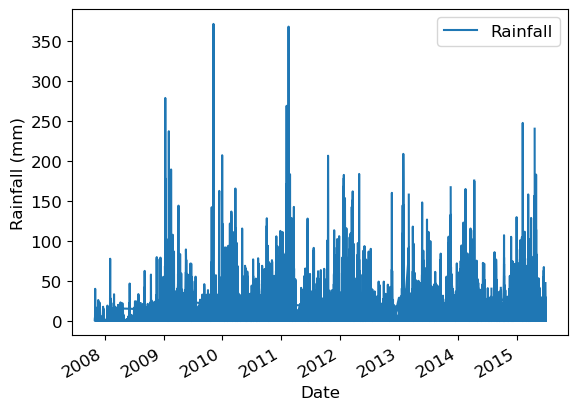

In [65]:
train_df.plot(x="Date", y="Rainfall")
plt.ylabel("Rainfall (mm)");

#### Lag-based features

In [66]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [67]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves with: 

In [68]:
# train_df.sort_values(by=["Location", "Date"])

But make sure to also sort the targets (i.e. do this before preprocessing).

We can "lag" (or "shift") a time series in Pandas with the .shift() method. 

In [69]:
train_df = train_df.assign(Rainfall_lag1=train_df["Rainfall"].shift(1))

In [70]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][:20]

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


- But we have multiple time series here and we need to be more careful with this. 
- When we switch from one location to another we do not want to take the value from the previous location. 

In [71]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code

    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby(
        "Location"
    ):  # Each location is its own time series
        new_df.loc[df_location.index[lag:], new_feature_name] = df_location.iloc[:-lag][
            orig_feature
        ].values
    return new_df

In [72]:
train_df = create_lag_feature(train_df, "Rainfall", 1)

In [73]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

,Date,Location,Rainfall,Rainfall_lag1
2309,2015-06-26,Albury,0.2,1.0
2310,2015-06-27,Albury,0.0,0.2
2311,2015-06-28,Albury,0.2,0.0
2312,2015-06-29,Albury,0.0,0.2
2313,2015-06-30,Albury,0.0,0.0
3040,2009-01-01,BadgerysCreek,0.0,NaN
3041,2009-01-02,BadgerysCreek,0.0,0.0
3042,2009-01-03,BadgerysCreek,0.0,0.0
3043,2009-01-04,BadgerysCreek,0.0,0.0
3044,2009-01-05,BadgerysCreek,0.0,0.0


Now it looks good! 

- Question: is it OK to do this to the test set? Discuss.
- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

In [74]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [75]:
rain_df_modified

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,NaN
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.6
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [76]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Rainfall_lag1"],
    categorical_features,
    drop_features,
    target
)

In [77]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [78]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

,Coef
Rainfall,0.081292
Rainfall_lag1,0.008040


- Rainfall from today has a positive coefficient. 
- Rainfall from yesterday has a positive but a smaller coefficient. 
- If we didn't have rainfall from today feature, rainfall from yesterday feature would have received a bigger coefficient.

- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also create lagged version of other features, or more lags

In [79]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 2)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 3)
rain_df_modified = create_lag_feature(rain_df_modified, "Humidity3pm", 1)

In [80]:
rain_df_modified[
    [
        "Date",
        "Location",
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
].head(10)

,Date,Location,Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm,Humidity3pm_lag1
0,2008-12-01,Albury,0.6,NaN,NaN,NaN,22.0,NaN
1,2008-12-02,Albury,0.0,0.6,NaN,NaN,25.0,22.0
2,2008-12-03,Albury,0.0,0.0,0.6,NaN,30.0,25.0
3,2008-12-04,Albury,0.0,0.0,0.0,0.6,16.0,30.0
4,2008-12-05,Albury,1.0,0.0,0.0,0.0,33.0,16.0
5,2008-12-06,Albury,0.2,1.0,0.0,0.0,23.0,33.0
6,2008-12-07,Albury,0.0,0.2,1.0,0.0,19.0,23.0
7,2008-12-08,Albury,0.0,0.0,0.2,1.0,19.0,19.0
8,2008-12-09,Albury,0.0,0.0,0.0,0.2,9.0,19.0
9,2008-12-10,Albury,1.4,0.0,0.0,0.0,27.0,9.0


Note the pattern of `NaN` values. 

In [81]:
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [82]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features
    + ["Rainfall_lag1", "Rainfall_lag2", "Rainfall_lag3", "Humidity3pm_lag1"],
    categorical_features,
    drop_features,
    target
)

In [83]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.85


In [84]:
lr_coef.loc[
    [
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
]

,Coef
Rainfall,0.107917
Rainfall_lag1,0.023105
Rainfall_lag2,0.018434
Rainfall_lag3,0.017829
Humidity3pm,1.278441
Humidity3pm_lag1,-0.266120


Note the pattern in the magnitude of the coefficients. 

<br><br><br><br>

## Final remarks 

What did we not cover?

- A huge amount!

### Traditional time series approaches

- Time series analysis is a huge field of its own 
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We took different route in this course, and stick to our supervised learning tools.

### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.

### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 19), LSTMs, and non deep learning methods.
- Inference problems
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
  - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

### Other software package

- A good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).
- [sktime](https://www.sktime.net/en/stable/get_started.html)
    - Time series classification
    - forecasting
- [tslearn](https://tslearn.readthedocs.io/en/stable/)
    - classification
    - regression
    - clustering

### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.
